In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from toolkit import EchelleSpectrum

In [2]:
import astropy.units as u
from astropy.io import fits

path = '/Users/bmmorris/data/cks/cks-k00003_bj122.81.fits'

hat11_spectrum = EchelleSpectrum.from_cks(path)

(3930, 3970)

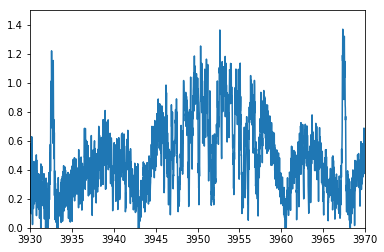

In [3]:
w = 3968*u.Angstrom

nearest_order = np.argmin(([abs(o.wavelength.mean() - w).value 
                            for o in hat11_spectrum.spectrum_list]))
order = hat11_spectrum.get_order(nearest_order)
order.plot()
plt.ylim([0, 1.5])
plt.xlim([3930, 3970])

In [221]:
from astropy.io import ascii
from astropy.table import Column
from astropy.constants import G, R_sun, M_sun, R_earth

table = ascii.read('q1_q17_dr25_koi.csv')

koinum_col = Column([row.split('.')[0] for row in table['kepoi_name'].data.data], 'koi_number')

table.add_column(koinum_col)
table.add_index('koi_number')

g = 10**table['koi_slogg'].data.data * u.cm / u.s**2
rstar = table['koi_srad'].data.data * R_sun
mstar = ((g * rstar**2 / G)/ M_sun).decompose()
mass_col = Column(mstar, 'koi_smass')
table.add_column(mass_col)

rplanet = table['koi_prad'].data.data * R_earth
planet_density = np.zeros(len(rplanet)) * u.g / u.cm**3
planet_density[rplanet >= 2 * R_earth] = 1 * u.g / u.cm**3
planet_density[rplanet < 2 * R_earth] = 5 * u.g / u.cm**3
table.add_column(Column(planet_density, 'assumed_density'))

brightness_score = 1 - 10**(-0.4*(table['koi_kepmag'].max() - table['koi_kepmag']) / table['koi_kepmag'].ptp())
table.add_column(Column(brightness_score, 'brightness_score'))

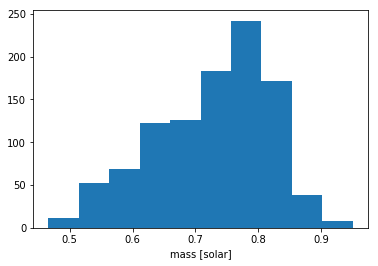

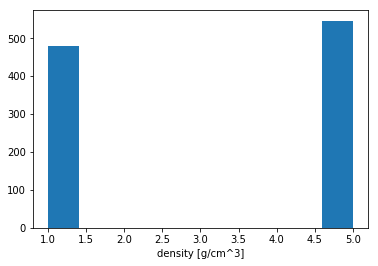

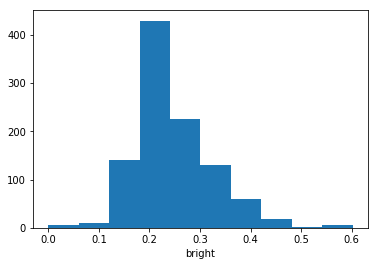

In [222]:
plt.hist(mstar)
plt.xlabel('mass [solar]')

plt.figure()
plt.hist(planet_density)
plt.xlabel('density [g/cm^3]')

plt.figure()
plt.hist(brightness_score)
plt.xlabel('bright')

KOI-3
KOI-82
KOI-104
KOI-144
KOI-148
KOI-153
KOI-161
KOI-163
KOI-174
KOI-197
KOI-241
KOI-305
KOI-313
KOI-315
KOI-338
KOI-345
KOI-346
KOI-348
KOI-387
KOI-416
KOI-440
KOI-446
KOI-457
KOI-475
KOI-490
KOI-505
KOI-518
KOI-520
KOI-543
KOI-561
KOI-569
KOI-574
KOI-579
KOI-582
KOI-612
KOI-657
KOI-701
KOI-719
KOI-733
KOI-749
KOI-757
KOI-825
KOI-835
KOI-837
KOI-853
KOI-869
KOI-872
KOI-874
KOI-881
KOI-884
KOI-892
KOI-896
KOI-906
KOI-921
KOI-941
KOI-958
KOI-988
KOI-999
KOI-1050
KOI-1069
KOI-1199
KOI-1300
KOI-1305
KOI-1360
KOI-1367
KOI-1428
KOI-1480
KOI-1557
KOI-1563
KOI-1567
KOI-1590
KOI-1619
KOI-1726
KOI-1781
KOI-1797
KOI-1803
KOI-1831
KOI-1835
KOI-1841
KOI-1871
KOI-1877
KOI-1891
KOI-1904
KOI-1905
KOI-1938
KOI-1985
KOI-2033
KOI-2037
KOI-2048
KOI-2073
KOI-2119
KOI-2120
KOI-2173
KOI-2219
KOI-2248
KOI-2250
KOI-2261
KOI-2281
KOI-2287
KOI-2290
KOI-2339
KOI-2393
KOI-2399
KOI-2442
KOI-2473
KOI-2498
KOI-2503
KOI-2521
KOI-2522
KOI-2529
KOI-2538
KOI-2694
KOI-2733
KOI-2790
KOI-2828
KOI-2931
KOI-3130
KOI-3158

(3929, 3939)

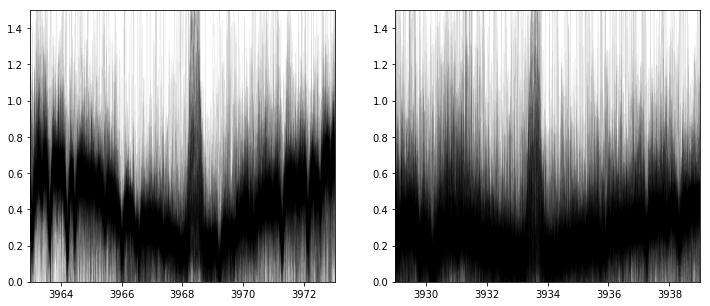

In [225]:
from astropy.utils.data import download_file 
from toolkit.activity import triangle_weighting
from astropy.table import Row

links = open('links_cached.txt').read().splitlines()

orders = []
#periods = []
#depths = []
table_entries = []

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for link in links:
    koi_number = int(link.split('/')[-1].split('-')[1].split('_')[0][1:])
    path = download_file(link, cache=True)
    
    koi_num_str = "K{0:05d}".format(koi_number)
    table_this_koi = table.loc[koi_num_str]
    
    if not isinstance(table_this_koi, Row):
        innermost_planet = np.argmin(table_this_koi['koi_period'])
#         periods.append(table_this_koi['koi_period'][innermost_planet])
#         depths.append(table_this_koi['koi_depth'][innermost_planet])
        table_entries.append(table_this_koi[innermost_planet])
    else: 
        table_entries.append(table_this_koi)
#         periods.append(table_this_koi['koi_period'])
#         depths.append(table_this_koi['koi_depth'])


    print('KOI-{0:d}'.format(koi_number))
    s = EchelleSpectrum.from_cks(path, name='KOI-{0:d}'.format(koi_number))
    
    rv_shift = s.rv_wavelength_shift(nearest_order, teff=4700)
    s.offset_wavelength_solution(rv_shift)

    order = s.get_order(nearest_order)
    orders.append(order)
    order.plot(ax=ax[0], lw=0.5, alpha=0.1, color='k')
    order.plot(ax=ax[1], lw=0.5, alpha=0.1, color='k')

ax[0].set_ylim([0, 1.5])
ax[0].set_xlim([3968-5, 3968+5])

ax[1].set_ylim([0, 1.5])
ax[1].set_xlim([3934-5, 3934+5])

For planets in the solar system, the densities are constant to within a factor of two, so $\rho \propto M/R^3 = const$. Thus $M \propto R^3$. Then since radii are inferred from transit depth via $R_p/R_s\propto \sqrt{\delta} $, and we're interested in scaling with the physical size of the planet $R_p$, 

$$  M \propto R_p^3 \sim \left( \frac{R_p}{R_s} R_s \right)^3 = \left( \sqrt{\delta} R_s \right)^3 = \delta^{3/2} R_s^3$$

**Then we assume that tides scale as $M_p a^{-3}$ where $a$ is the innermost planet semimajor axis.** We can get the semimajor axis from Kepler's third: 

$$ a = \left(P^2 \frac{GM_s}{4\pi^2}\right)^{1/3}$$

Since we don't have stellar masses, let's take the approximation that $M_s \propto R_s$ for sun-like stars, thus

$$ a \propto \left(P^2 R_s\right)^{1/3}$$

In [ ]:
from scipy.stats import binned_statistic

# def normalize_order(order):
#     norm_band = (order.wavelength > 3945*u.Angstrom) & (order.wavelength < 3960*u.Angstrom)
#     return order.flux/np.nanmedian(order.flux[norm_band])
#    #return order.flux/np.nanmean(order.flux[order.wavelength > 3980*u.Angstrom])

def median_normalize(order):
    return order.flux/np.nanmean(order.flux[order.wavelength > 3980*u.Angstrom])

def normalize_order(order, model, plot=False):
    model_slice = slice_spectrum(model,
                                 order.masked_wavelength.min(),
                                 order.masked_wavelength.max(),
                                 norm=order.masked_flux.max())
    interp_target_slice = interpolate_spectrum(order, model_slice.wavelength)
    
    flux_ratio = median_normalize(interp_target_slice) / median_normalize(model_slice)

    binfluxratio = binned_statistic(model_slice.wavelength, flux_ratio, 
                                    statistic='median', bins=20)
    bin_x = 0.5*(binfluxratio.bin_edges[1:] + binfluxratio.bin_edges[:-1])
    bin_y = binfluxratio.statistic
    fitp = np.polyfit(bin_x, bin_y, 1)
    if plot:
        plt.figure()
        plt.plot(model_slice.wavelength, flux_ratio, '.')
        plt.plot(bin_x, bin_y)
        plt.plot(model_slice.wavelength, np.polyval(fitp, model_slice.wavelength))
        plt.ylim([0, 3])
        plt.show()
    return median_normalize(order) / np.polyval(fitp, order.wavelength)
    
#order = orders[11]
#normed_flux = normalize_order(order)

from toolkit.spectra import sigma_clipper
from sklearn.neighbors import KernelDensity
from toolkit.activity import triangle_weighting, true_h_centroid, true_k_centroid

hk_fluxes = np.zeros(len(orders))
for i, order in enumerate(orders):
    tri_weights = (triangle_weighting(order.wavelength, true_h_centroid) + 
                   triangle_weighting(order.wavelength, true_k_centroid))
    hk_fluxes[i] = np.sum(tri_weights * normalize_order(order, hat11_spectrum.model_spectrum))
    
    if False:
        plt.figure()
        plt.plot(order.wavelength, normalize_order(order, hat11_spectrum.model_spectrum))
        plt.plot(order.wavelength, tri_weights)
        plt.ylim([0,2])
        plt.show()

periods = np.array([r['koi_period'] for r in table_entries])
depths = np.array([r['koi_depth'] for r in table_entries])
pradii = np.array([r['koi_prad'] for r in table_entries])
rstar = np.array([r['koi_srad'] for r in table_entries])
mstar = np.array([r['koi_smass'] for r in table_entries])
pdensity = np.array([r['assumed_density'] for r in table_entries])
brightness = np.array([r['brightness_score'] for r in table_entries])
tidal_factor = depths**1.5 * rstar**3 * pdensity / (mstar * periods**2)
log_tides = np.log(tidal_factor)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
set_params = dict(ylim=[0, 100])
scatter_params = dict(c=brightness, cmap=plt.cm.plasma_r)
ax[0, 0].scatter(periods, hk_fluxes, **scatter_params)
ax[0, 0].set(xlabel='period', ylabel='$F_{HK}$', **set_params)

ax[0, 1].scatter(pradii, hk_fluxes, **scatter_params)
ax[0, 1].set(xlabel='radius [$R_\oplus$]', ylabel='$F_{HK}$', **set_params)

ax[1, 0].scatter(kepmags, hk_fluxes, **scatter_params)
ax[1, 0].set(xlabel='Kep mag', ylabel='$F_{HK}$', **set_params)

ax[1, 1].scatter(log_tides, hk_fluxes, **scatter_params)
ax[1, 1].set(xlabel='log(tidal factor)', ylabel='$F_{HK}$', **set_params)
#ax[1, 1].contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)

In [ ]:
# tri_weights = (triangle_weighting(order.wavelength, true_h_centroid) + 
#                triangle_weighting(order.wavelength, true_k_centroid))

# rv_shift = hat11_spectrum.rv_wavelength_shift(nearest_order, plot=True, teff=4700)
# hat11_spectrum.offset_wavelength_solution(rv_shift)

# plt.figure(figsize=(12, 5))
# plt.plot(order.wavelength, order.flux/np.median(order.flux))
# plt.plot(hat11_spectrum.model_spectrum.wavelength, 
#          10 * hat11_spectrum.model_spectrum.flux/np.max(hat11_spectrum.model_spectrum.flux))
# plt.plot(order.wavelength, tri_weights, 'r')
# plt.xlim([order.wavelength.value.min(), order.wavelength.value.max()])
# plt.ylim([0, 10])

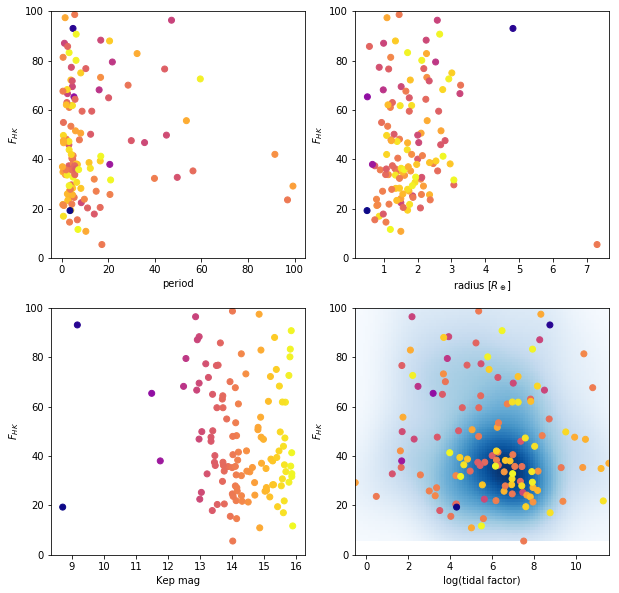

In [305]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def compute_kde(x, y):
    m1 = x
    m2 = y
    xmin, xmax = m1.min(), m1.max()
    ymin, ymax = m2.min(), m2.max()
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([m1, m2])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    return Z

def plot_kde(x, y, Z, axis):
    m1 = x
    m2 = y
    xmin, xmax = m1.min(), m1.max()
    ymin, ymax = m2.min(), m2.max()
    axis.imshow(np.rot90(Z), cmap=plt.cm.Blues,
                extent=[xmin, xmax, ymin, ymax])
    axis.set_aspect('auto')
    
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
set_params = dict(ylim=[0, 100])
scatter_params = dict(c=brightness, cmap=plt.cm.plasma_r)
ax[0, 0].scatter(periods, hk_fluxes, **scatter_params)
ax[0, 0].set(xlabel='period', ylabel='$F_{HK}$', **set_params)

ax[0, 1].scatter(pradii, hk_fluxes, **scatter_params)
ax[0, 1].set(xlabel='radius [$R_\oplus$]', ylabel='$F_{HK}$', **set_params)

ax[1, 0].scatter(kepmags, hk_fluxes, **scatter_params)
ax[1, 0].set(xlabel='Kep mag', ylabel='$F_{HK}$', **set_params)

ax[1, 1].scatter(log_tides, hk_fluxes, **scatter_params)
ax[1, 1].set(xlabel='log(tidal factor)', ylabel='$F_{HK}$', **set_params)

Z = compute_kde(log_tides, hk_fluxes)
plot_kde(log_tides, hk_fluxes, Z, ax[1, 1])